In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from galaxy_generator import simulate_perfect_galaxy, add_source_to_image, sky_noise

Generate an array of galaxy & image properties:

In [72]:
N = 5

## Range of values to try
lims = {
    'mag' : (12, 18),
    'sky_mag' : (20, 26),
    'n_clumps' : (5, 30),
    'psf_fwhm' : (0.2, 3),
    'sersic_n' : (1, 4),
    'px' : (0.1, 0.5),
}

# Generate parameters for n galaxies
mags = stats.uniform.rvs(loc=lims['mag'][0], scale=lims['mag'][1] - lims['mag'][0], size=N)
ns = stats.uniform.rvs(loc=lims['sersic_n'][0], scale=lims['sersic_n'][1] - lims['sersic_n'][0], size=N)
sky_mags = stats.uniform.rvs(loc=lims['sky_mag'][0], scale=lims['sky_mag'][1] - lims['sky_mag'][0], size=N)
n_clumps = np.random.randint(low=lims['n_clumps'][0], high=lims['n_clumps'][1], size=N)
psfs = stats.uniform.rvs(loc=lims['psf_fwhm'][0], scale=lims['psf_fwhm'][1] - lims['psf_fwhm'][0], size=N)
pxscales = stats.uniform.rvs(loc=lims['px'][0], scale=lims['px'][1] - lims['px'][0], size=N)
for i in range(N):
    pxscales[i] = np.min([pxscales[i], psfs[i]/2])
    
qs = stats.uniform.rvs(loc=0.2, scale=0.8, size=N)
qs[ns > 3.5] = 1.0
rs = -1.9*mags + 35 + stats.norm.rvs(loc=0, scale=1.5, size=N)
rs[rs <= 1] = 1
rs[rs >= 20] = 20


Generate a perfect and noisy galaxy pair:

In [104]:
def single_galaxy_run(mag, r_eff, sersic_n, q, n_clumps, sky_mag, psf_fwhm, pxscale):

    perfect_px = 0.1
    rs = np.random.random(n_clumps)*(1-0.05)+0.05
    # fs = np.random.random(n_clumps)*(0-0.1) 
    

    # flux_fracs = 10**np.linspace(np.log10(0.05), np.log10(0.1), len(xvals))
    fs = np.random.random(n_clumps)*(-1+5)-5
    fs = np.power(10, fs)
    

    smin = 0.1
    smax = 3
    sigs = np.random.random(n_clumps)*(smax-smin) + smin
    thetas = np.random.random(n_clumps)*360

    fs = np.power(10, fs)

    clump_properties = {
        'r' : rs,
        'theta' : thetas,
        'flux' : fs,
        'sigma' : sigs
    }

    # Generate galaxy model at two resolutions
    image_perfect, params_res, r_pet_res = simulate_perfect_galaxy(mag, r_eff, perfect_px, 10, sersic_n, q, 0, n_clumps, clump_properties)
    img, params, r_pet = simulate_perfect_galaxy(mag, r_eff, pxscale, 10, sersic_n, q, 0, n_clumps, clump_properties)

    # Convolve with PSF
    image_perfect = add_source_to_image(**params_res, psf_fwhm=0, pxscale=perfect_px, psf_method="astropy")
    image_psf = add_source_to_image(**params, psf_fwhm=psf_fwhm, pxscale=pxscale, psf_method="astropy")
    image_noisy, sky_flux = sky_noise(image_psf, sky_mag=sky_mag, pixel_scale=pxscale, rms_noise=True)

    return image_perfect, image_noisy 


Generate `N` galaxies:

In [105]:
perfects = []
noisies = []

for n in range(N):
    
    perfect, noisy = single_galaxy_run(mags[n],rs[n], ns[n], qs[n], n_clumps[n], sky_mags[n], psfs[n], pxscales[n])
    perfects.append(perfect)
    noisies.append(noisy)

Plot them:

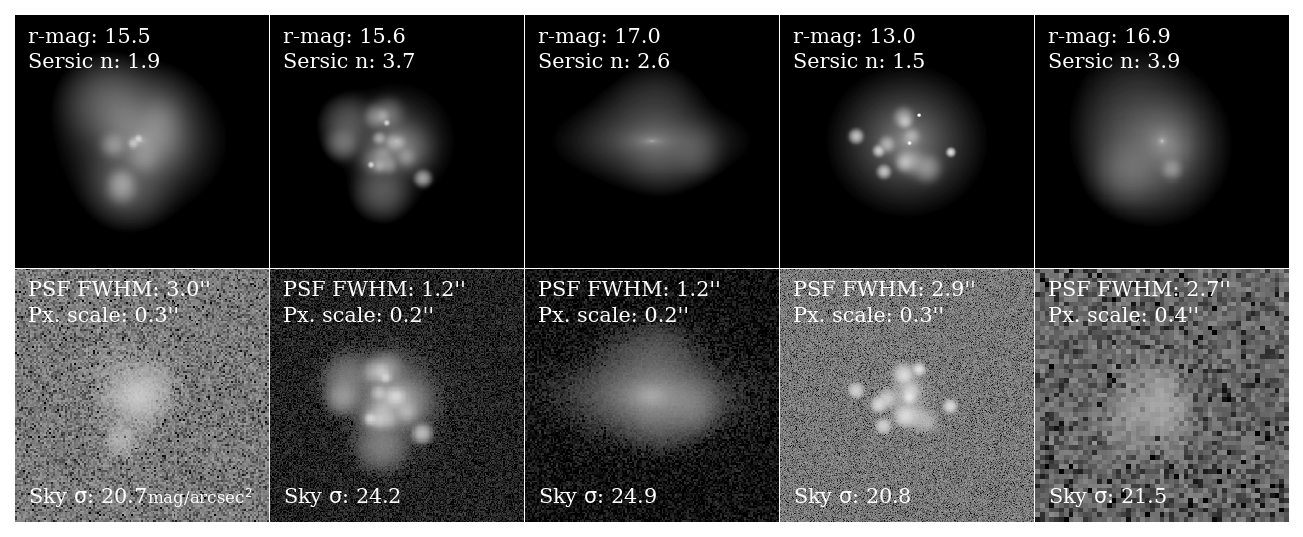

In [106]:
# fig, axs = plt.subplots(2,5,figsize=(15.5,6.1), dpi=100)
fig, axs = plt.subplots(2,5,figsize=(8.5,3.38), dpi=150)

for i in range(N):
    axs[0,i].imshow(-2.5*np.log10(np.abs(perfects[i])/0.1**2) + 33, vmin=17, vmax=27, cmap='gray_r')
    axs[1,i].imshow(-2.5*np.log10(np.abs(noisies[i])/(pxscales[i]/2)**2) + 33, vmin=17, vmax=27, cmap='gray_r')
    
    axs[0,i].annotate(f'r-mag: {mags[i]:0.1f}', xy=(0.05,0.95), xycoords='axes fraction', size=10, color='w', va='top', ha='left')
    axs[0,i].annotate(f'Sersic n: {ns[i]:0.1f}', xy=(0.05,0.85), xycoords='axes fraction', size=10, color='w', va='top', ha='left')
    axs[1,i].annotate(f'PSF FWHM: {psfs[i]:0.1f}\'\'', xy=(0.05,0.95), xycoords='axes fraction', size=10, color='w', va='top', ha='left')
    axs[1,i].annotate(f'Px. scale: {pxscales[i]:0.1f}\'\'', xy=(0.05,0.85), xycoords='axes fraction', size=10, color='w', va='top', ha='left')
    axs[1,i].annotate(fr'Sky $\sigma$: {sky_mags[i]:0.1f}', xy=(0.05,0.05), xycoords='axes fraction', size=10, color='w', va='bottom', ha='left')
    
axs[1,0].annotate(fr'mag/arcsec$^2$', xy=(0.52,0.048), xycoords='axes fraction', size=8, color='w', va='bottom', ha='left')
plt.subplots_adjust(wspace=0.001, hspace=0.001)
for ax in axs.flatten():
    ax.axis('off')
    
plt.savefig('figures/paper/galsim.pdf', bbox_inches='tight')

In [ ]:
dots per inch

In [88]:
8.5/(5+0.01*4) * (2+0.01)

3.389880952380952